In [1]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F

In [2]:
spark = SparkSession.builder.appName('MySparkApp').getOrCreate()

## PySpark Steps

In [3]:
df = spark.read.csv('rotten_tomatoes_movies.csv', header=True, inferSchema=True)

In [4]:
df.show(10)

+--------------------+--------------------+-------------+-----------+------+--------------------+-------------------+--------------------+--------------+--------------------+----------------+--------------------+--------------------+---------+-----------+--------+
|                  id|               title|audienceScore|tomatoMeter|rating|      ratingContents|releaseDateTheaters|releaseDateStreaming|runtimeMinutes|               genre|originalLanguage|            director|              writer|boxOffice|distributor|soundMix|
+--------------------+--------------------+-------------+-----------+------+--------------------+-------------------+--------------------+--------------+--------------------+----------------+--------------------+--------------------+---------+-----------+--------+
|  space-zombie-bingo| Space Zombie Bingo!|           50|       NULL|  NULL|                NULL|               NULL|          2018-08-25|            75|Comedy, Horror, S...|         English|       George 

In [5]:
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- audienceScore: integer (nullable = true)
 |-- tomatoMeter: integer (nullable = true)
 |-- rating: string (nullable = true)
 |-- ratingContents: string (nullable = true)
 |-- releaseDateTheaters: date (nullable = true)
 |-- releaseDateStreaming: string (nullable = true)
 |-- runtimeMinutes: integer (nullable = true)
 |-- genre: string (nullable = true)
 |-- originalLanguage: string (nullable = true)
 |-- director: string (nullable = true)
 |-- writer: string (nullable = true)
 |-- boxOffice: string (nullable = true)
 |-- distributor: string (nullable = true)
 |-- soundMix: string (nullable = true)



### Cleaning

Removing rows with null values in AudienceScore, tomatoMeter, or releaseDateTheaters

In [6]:
df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in ['audienceScore', 'tomatoMeter', 'releaseDateTheaters']]).show()

+-------------+-----------+-------------------+
|audienceScore|tomatoMeter|releaseDateTheaters|
+-------------+-----------+-------------------+
|        70010|     109381|             112485|
+-------------+-----------+-------------------+



In [7]:
df = df.na.drop(subset=['audienceScore', 'tomatoMeter', 'releaseDateTheaters'])

In [8]:
df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in ['audienceScore', 'tomatoMeter', 'releaseDateTheaters']]).show()

+-------------+-----------+-------------------+
|audienceScore|tomatoMeter|releaseDateTheaters|
+-------------+-----------+-------------------+
|            0|          0|                  0|
+-------------+-----------+-------------------+



### Processing
Creating a new column named "year" using the release date column

In [9]:
df = df.withColumn('year', F.year(df.releaseDateTheaters))

In [10]:
df.select('year').show()

+----+
|year|
+----+
|2018|
|1947|
|2009|
|2011|
|2005|
|2017|
|1963|
|1996|
|2009|
|1991|
|2002|
|2017|
|2022|
|2015|
|1993|
|2012|
|2019|
|2017|
|2014|
|2004|
+----+
only showing top 20 rows



In [11]:
df = df.orderBy(F.desc('tomatoMeter')).limit(5000)

### Save as Parquet

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [13]:
df.write.parquet('processed.parquet', mode='overwrite')

In [14]:
df = pd.read_parquet('processed.parquet')

## EDA Exploration

In [15]:
df.head()

,id,title,audienceScore,tomatoMeter,rating,ratingContents,releaseDateTheaters,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director,writer,boxOffice,distributor,soundMix,year
0,sometimes_a_great_notion,Sometimes a Great Notion,77,100,None,None,1972-01-19,2011-01-31,114.0,Drama,English,Paul Newman,John Gay,None,Universal Pictures,Stereo,1972
1,berkeley_in_the_sixties,Berkeley in the Sixties,76,100,None,None,1990-01-01,2002-12-10,117.0,Documentary,English,Mark Kitchell,Mark Kitchell,None,"First Run, California Newsreel",None,1990
2,more_than_honey,More Than Honey,79,100,None,None,2013-06-12,2014-03-18,95.0,Documentary,German,Markus Imhoof,None,$71.5K,Kino Lorber,None,2013
3,tiger_24,Tiger 24,95,100,None,None,2022-06-10,2022-12-06,90.0,Documentary,English,Warren Pereira,Warren Pereira,None,Elevation Pictures,None,2022
4,atlantic_city,Atlantic City,77,100,None,None,1981-04-03,2013-01-01,104.0,"Comedy, Drama",English,Louis Malle,John Guare,None,Paramount Pictures,None,1981


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    5000 non-null   object 
 1   title                 5000 non-null   object 
 2   audienceScore         5000 non-null   int32  
 3   tomatoMeter           5000 non-null   int32  
 4   rating                1266 non-null   object 
 5   ratingContents        1266 non-null   object 
 6   releaseDateTheaters   5000 non-null   object 
 7   releaseDateStreaming  4635 non-null   object 
 8   runtimeMinutes        4994 non-null   float64
 9   genre                 5000 non-null   object 
 10  originalLanguage      4911 non-null   object 
 11  director              4996 non-null   object 
 12  writer                4035 non-null   object 
 13  boxOffice             2539 non-null   object 
 14  distributor           4398 non-null   object 
 15  soundMix             

<Axes: xlabel='tomatoMeter', ylabel='audienceScore'>

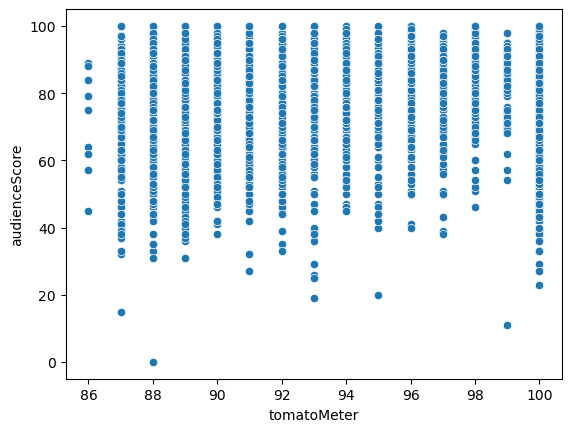

In [17]:
sns.scatterplot(df, x='tomatoMeter', y='audienceScore')

In [18]:
df_avg_year = df.groupby('year')[['audienceScore', 'tomatoMeter']].mean().reset_index()
df_avg_year.head()

,year,audienceScore,tomatoMeter
0,1902,90.000000,100.000000
1,1914,42.000000,90.000000
2,1915,56.666667,93.666667
3,1916,78.500000,93.000000
4,1919,69.000000,95.000000


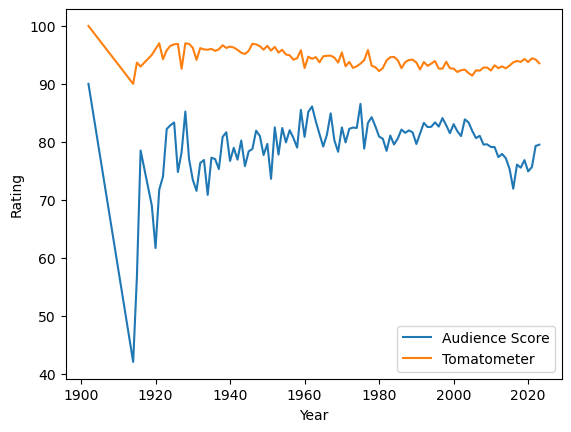

In [19]:
fig, ax = plt.subplots()
ax.plot(df_avg_year.year, df_avg_year.audienceScore, label='Audience Score')
ax.plot(df_avg_year.year, df_avg_year.tomatoMeter, label='Tomatometer')
ax.set_xlabel('Year')
ax.set_ylabel('Rating')
ax.legend()

In [20]:
df_avg_lang = df.groupby('originalLanguage')[['audienceScore', 'tomatoMeter']].mean().reset_index()

In [21]:
lang_list = ['Arabic', 'Yiddish', 'English', 'Chinese', 'French', 'Spanish']

In [22]:
df_avg_lang = df_avg_lang.loc[df_avg_lang.originalLanguage.isin(lang_list)]

In [23]:
df_avg_lang

,originalLanguage,audienceScore,tomatoMeter
2,Arabic,81.021277,93.893617
9,Chinese,79.391753,93.917526
15,English,78.583358,93.736350
21,French,92.000000,94.000000
61,Spanish,75.722772,93.415842
76,Yiddish,64.500000,97.500000


In [29]:
df_avg_lang = df_avg_lang.melt(id_vars=['originalLanguage'], value_vars=['audienceScore', 'tomatoMeter'], var_name='Rated By', value_name='Rating')

In [30]:
df_avg_lang

,originalLanguage,Rated By,Rating
0,Arabic,audienceScore,81.021277
1,Chinese,audienceScore,79.391753
2,English,audienceScore,78.583358
3,French,audienceScore,92.000000
4,Spanish,audienceScore,75.722772
5,Yiddish,audienceScore,64.500000
6,Arabic,tomatoMeter,93.893617
7,Chinese,tomatoMeter,93.917526
8,English,tomatoMeter,93.736350
9,French,tomatoMeter,94.000000


<Axes: xlabel='originalLanguage', ylabel='Rating'>

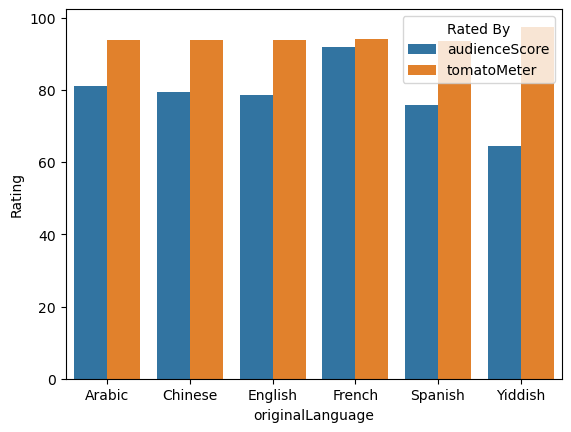

In [33]:
sns.barplot(df_avg_lang, x='originalLanguage', y='Rating', hue='Rated By')